# The Machine Learning Framework:

By the end of this assignment, I hope you begin to feel like a real data scientist. 

For your assignment I have obtained a dataset of 3333 records of cell phone user data. Your mission -should you choose to accept it- is to train a model that can predict whether or not a user "churns" -cancels their plan at the end of the month. 

The purpose of this assignment is for you to familiarize yourself with what we call **The Machine Learning Framework**:

![The Machine Learning Framework](http://www.ryanleeallred.com/wp-content/uploads/2018/05/machine-learning-framework-1.png)

This will be one of your first opportunities to go from A-Z on a project. What's exciting about this assignment is that you are free to do whatever you think will get you the best performing classifier using the Machine Learning Framework as a guide. 

What is also exciting about this assignment is that we will be using a private Kaggle competition to score your models!

## The Process: 

**You shouldn't just go through the cycle pictured above just once.**

Start off by doing what seems like the *bare minimum* in order to train your classifier and make predictions that are slightly better than random. As you explore the data, make a note of ways that you can improve your model. Then, after you have made your first-pass predictions, prioritize your list of improvements based on their difficulty and estimated value. Each time you make an improvement, re-train and re-validate your model to see if your changes have truly made your classifier better. 

As you go through this cycle of improving your data/model and validating your improvements, your predictions will get better and better until you simply run out of time to make more improvements.  


## Business Understanding

Gaining domain knowledge and a business understanding about a problem is extremely useful. It wil help you communicate your findings to stakeholders and give you insights about the data exploration process.

[What is churn analysis?](https://www.datascience.com/blog/what-is-a-churn-analysis-and-why-is-it-valuable-for-business)

[The importance of predicting customer churn ](https://www.optimove.com/learning-center/customer-churn-prediction-and-prevention)

## The Data:

You will have access to a randomly selected 66.66% of the data for your training dataset. This will have all of the columns **including** whether or not the customer churned. The other 33.33% will be in the test dataset **without** any information about the customer churn. You will run experiments on the training dataset, but ultimately will be required to make predictions and submissions to our private Kaggle Leaderboard using the test dataset.

## [Access the data and the Kaggle leaderboard here](https://www.kaggle.com/t/148ead80810e46ae8383517a543756dd)

**You are going to need to create an account on Kaggle if you don't already have one.**

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [196]:
train_raw = pd.read_csv('https://raw.githubusercontent.com/ryanleeallred/churn-data/master/train.csv')
test_raw = pd.read_csv('https://raw.githubusercontent.com/ryanleeallred/churn-data/master/test.csv')
submit_raw = pd.read_csv('https://raw.githubusercontent.com/ryanleeallred/churn-data/master/sampleSubmission.csv')

train_raw.head()

,id,state,account_length,area_code,phone,international_plan,vmail_plan,vmail_message,day_mins,day_calls,...,eve_calls,eve_charge,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,custserv_calls,churn
0,3200,CT,100,510,416-1536,yes,no,0,107.2,98,...,122,7.38,156.2,117,7.03,9.7,4,2.62,1,0
1,2129,CT,146,408,380-3329,no,yes,23,149.6,96,...,124,20.38,293.5,135,13.21,7.4,4,2,2,0
2,598,AZ,84,415,341-2360,no,no,0,159.0,80,...,128,14.27,167.6,101,7.54,12.3,5,3.32,1,0
3,2507,VT,43,408,331-8713,no,no,0,135.8,125,...,88,13.87,229.8,106,10.34,12.6,?,3.4,0,0
4,1248,PA,101,415,368-2074,?,no,0,193.7,108,...,?,15.86,223.0,100,?,11.6,8,3.13,0,0


## Data Preparation

You will probably go back and forth between data preparation and data understanding. Some of the data you won't be able to explore until it is cleaned, and vice versa.

Real world data is messy, and this dataset is no exception. Start off by identifying the features that seem useful, and work on cleaning/preparing those columns first. Remember that you don't have to use every column of a dataset when you are fitting your model.

### Missing Values

To fill missing values, I will use the most frequent category for the categorical variables (e.g. `international plan`). For the missing numeric values, I will calculate the average relationship between minutes, calls, and charge, and fill accordingly on a case-by-case basis.

In [0]:
categorical_features = ['state', 'area_code', 'international_plan', 'vmail_plan']
integer_features = ['account_length', 'day_calls', 'eve_calls', 'night_calls', 'intl_calls', 'custserv_calls']
continuous_features = ['day_mins', 'day_charge', 'eve_mins', 'eve_charge', 
                       'night_mins', 'night_charge', 'intl_mins', 'intl_charge']

churn = train_raw[['churn']]
train = train_raw.drop('churn', axis=1).replace('?', np.nan)

for feature in categorical_features:
    train[feature] = train[feature].fillna(train[feature].mode()[0])

# some numeric features are actually strings, or some other non-numeric data type
for feature in integer_features+continuous_features:
    train[feature] = train[feature].astype(np.float64)

In [198]:
train['day_charge'].iloc[:5] / train['day_mins'][:5]

0    0.169963
1    0.169987
2    0.170000
3    0.170029
4    0.170005
dtype: float64

In [199]:
train['intl_charge'].iloc[:5] / train['intl_mins'][:5]

0    0.270103
1    0.270270
2    0.269919
3    0.269841
4    0.269828
dtype: float64

It seems there is a relatively stable relationship between minutes are charge. I will check for the average minutes per call, and then use this data to fill in my missing numeric values.

In [0]:
day_charge_per_min = np.mean(train['day_charge'] / train['day_mins'])
eve_charge_per_min = np.mean(train['eve_charge'] / train['eve_mins'])
night_charge_per_min = np.mean(train['night_charge'] / train['night_mins'])
intl_charge_per_min = np.mean(train['intl_charge'] / train['intl_mins'])

charge_min_ratios = [day_charge_per_min, eve_charge_per_min, night_charge_per_min, intl_charge_per_min]
min_charge_ratios = [1/r for r in charge_min_ratios]

day_calls_per_min = int(np.mean(train['day_calls'] / train['day_mins']))
eve_calls_per_min = int(np.mean(train['eve_calls'] / train['eve_mins']))
night_calls_per_min = int(np.mean(train['night_calls'] / train['night_mins']))
intl_calls_per_min = int(np.mean(train['intl_calls'] / train['intl_mins']))

calls_min_ratios = [day_calls_per_min, eve_calls_per_min, night_calls_per_min, intl_calls_per_min]

In [201]:
feature_suffixes = ['mins', 'charge', 'calls']
anchor_suffixes = ['charge', 'mins', 'mins']
ratios_collection = [min_charge_ratios, charge_min_ratios, calls_min_ratios]

feature_prefixes = ['day_', 'eve_', 'night_', 'intl_']

for suffix, anchor_s, ratios in zip(feature_suffixes, anchor_suffixes, ratios_collection):
    for prefix, ratio in zip(feature_prefixes, ratios):
        feature = prefix + suffix
        anchor = prefix + anchor_s
        
        fill = train[anchor] * ratio
        fill = fill.fillna(fill.mean())
        
        train[feature] = train[feature].fillna(fill)
        
print('Any nulls remaining:', train.isnull().any().any())
train.head()

Any nulls remaining: False


,id,state,account_length,area_code,phone,international_plan,vmail_plan,vmail_message,day_mins,day_calls,...,eve_mins,eve_calls,eve_charge,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,custserv_calls
0,3200,CT,100.0,510,416-1536,yes,no,0,107.2,98.0,...,86.8,122.0,7.38,156.2,117.0,7.030000,9.7,4.0,2.62,1.0
1,2129,CT,146.0,408,380-3329,no,yes,23,149.6,96.0,...,239.8,124.0,20.38,293.5,135.0,13.210000,7.4,4.0,2.00,2.0
2,598,AZ,84.0,415,341-2360,no,no,0,159.0,80.0,...,167.9,128.0,14.27,167.6,101.0,7.540000,12.3,5.0,3.32,1.0
3,2507,VT,43.0,408,331-8713,no,no,0,135.8,125.0,...,163.2,88.0,13.87,229.8,106.0,10.340000,12.6,0.0,3.40,0.0
4,1248,PA,101.0,415,368-2074,no,no,0,193.7,108.0,...,186.6,0.0,15.86,223.0,100.0,10.034979,11.6,8.0,3.13,0.0


In [0]:
# integer features were floats in order to have nans. convert back to integers now

for feature in integer_features:
    train[feature] = train[feature].astype(np.int64)

### Selecting and Encoding Features

Since `id` is unique to the individual customer. It will not have predictive value. I will drop this from the data that I train on, although when making predictions on the test set it will be important to know which prediction corresponds to which id. Similarly, `phone` almost serves as a second id, and I expect it to be mostly unique to the customer, not providing much predictive value.

Although tree-based algorithms can work with unencoded categorical features, they work just as well when these are encoded, and most other algorithms require all features to be encoded as numbers. There is a bit of a problem when it comes to features like state that have many values, but have no meaningful ordering. For now, I will integer encode them, but may use one-hot encodings specifically for certain models, and may often not use the features at all.

In [203]:
from sklearn.preprocessing import LabelEncoder

train_enc = train.drop(['id', 'phone'], axis=1)

for feature in categorical_features:
    train_enc[feature] = LabelEncoder().fit_transform(train_enc[feature])
    
train_one_hot = pd.get_dummies(train.drop(['id', 'phone'], axis=1))

print('One-Hot Encoded:')
display(train_one_hot.head())
print('Shape:', train_one_hot.shape)

print('Integer Encoded:')
display(train_enc.head())
print('Shape:', train_enc.shape)

One-Hot Encoded:


,account_length,vmail_message,day_mins,day_calls,day_charge,eve_mins,eve_calls,eve_charge,night_mins,night_calls,...,state_WI,state_WV,state_WY,area_code_408,area_code_415,area_code_510,international_plan_no,international_plan_yes,vmail_plan_no,vmail_plan_yes
0,100,0,107.2,98,18.22,86.8,122,7.38,156.2,117,...,0,0,0,0,0,1,0,1,1,0
1,146,23,149.6,96,25.43,239.8,124,20.38,293.5,135,...,0,0,0,1,0,0,1,0,0,1
2,84,0,159.0,80,27.03,167.9,128,14.27,167.6,101,...,0,0,0,0,1,0,1,0,1,0
3,43,0,135.8,125,23.09,163.2,88,13.87,229.8,106,...,0,0,0,1,0,0,1,0,1,0
4,101,0,193.7,108,32.93,186.6,0,15.86,223.0,100,...,0,0,0,0,1,0,1,0,1,0


Shape: (2222, 73)
Integer Encoded:


,state,account_length,area_code,international_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,eve_mins,eve_calls,eve_charge,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,custserv_calls
0,6,100,2,1,0,0,107.2,98,18.22,86.8,122,7.38,156.2,117,7.030000,9.7,4,2.62,1
1,6,146,0,0,1,23,149.6,96,25.43,239.8,124,20.38,293.5,135,13.210000,7.4,4,2.00,2
2,3,84,1,0,0,0,159.0,80,27.03,167.9,128,14.27,167.6,101,7.540000,12.3,5,3.32,1
3,46,43,0,0,0,0,135.8,125,23.09,163.2,88,13.87,229.8,106,10.340000,12.6,0,3.40,0
4,38,101,1,0,0,0,193.7,108,32.93,186.6,0,15.86,223.0,100,10.034979,11.6,8,3.13,0


Shape: (2222, 19)


### Feature Scaling

Some algorithms, such as K-Nearest Neighbors, are sensitive to the scale of the data. I will create a version of the data with rescaled features for use with these models.

In [204]:
from sklearn.preprocessing import StandardScaler

train_enc_scaled = pd.DataFrame(StandardScaler().fit_transform(train_enc), columns=train_enc.columns)
train_one_hot_scaled = pd.DataFrame(StandardScaler().fit_transform(train_one_hot), columns=train_one_hot.columns)

train_enc_scaled.head()

,state,account_length,area_code,international_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,eve_mins,eve_calls,eve_charge,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,custserv_calls
0,-1.400177,-0.006865,1.460422,3.409545,-0.556904,-0.579395,-1.316713,-0.101346,-1.317207,-2.257157,0.933670,-2.256715,-0.868827,0.865660,-0.868360,-0.190658,0.146592,-0.190105,-0.446258
1,-1.400177,1.137743,-1.464371,-0.293294,1.795643,1.106472,-0.538214,-0.202806,-0.538490,0.789452,0.983028,0.788694,1.864227,1.790098,1.865258,-1.015700,0.146592,-1.013807,0.329023
2,-1.603638,-0.404989,-0.001974,-0.293294,-0.556904,-0.579395,-0.365622,-1.014487,-0.365682,-0.642255,1.081744,-0.642648,-0.641902,0.043938,-0.642770,0.741999,0.497213,0.739881,-0.446258
3,1.312639,-1.425183,-1.464371,-0.293294,-0.556904,-0.579395,-0.791593,1.268365,-0.791222,-0.735844,0.094584,-0.736353,0.596233,0.300726,0.595763,0.849613,-1.255892,0.846165,-1.221539
4,0.770076,0.018018,-0.001974,-0.293294,-0.556904,-0.579395,0.271498,0.405955,0.271549,-0.269892,-2.077167,-0.270171,0.460875,-0.007419,0.460842,0.490899,1.549075,0.487456,-1.221539


### Processing Test Data
I will quickly repeat all the above steps on the test data.

In [0]:
test = test_raw.drop('churn', axis=1).replace('?', np.nan)

for feature in categorical_features:
    test[feature] = test[feature].fillna(test[feature].mode()[0])

# some numeric features are actually strings, or some other non-numeric data type
for feature in integer_features+continuous_features:
    test[feature] = test[feature].astype(np.float64)
    
day_charge_per_min = np.mean(test['day_charge'] / test['day_mins'])
eve_charge_per_min = np.mean(test['eve_charge'] / test['eve_mins'])
night_charge_per_min = np.mean(test['night_charge'] / test['night_mins'])
intl_charge_per_min = np.mean(test['intl_charge'] / test['intl_mins'])

charge_min_ratios = [day_charge_per_min, eve_charge_per_min, night_charge_per_min, intl_charge_per_min]
min_charge_ratios = [1/r for r in charge_min_ratios]

day_calls_per_min = int(np.mean(test['day_calls'] / test['day_mins']))
eve_calls_per_min = int(np.mean(test['eve_calls'] / test['eve_mins']))
night_calls_per_min = int(np.mean(test['night_calls'] / test['night_mins']))
intl_calls_per_min = int(np.mean(test['intl_calls'] / test['intl_mins']))

calls_min_ratios = [day_calls_per_min, eve_calls_per_min, night_calls_per_min, intl_calls_per_min]

feature_suffixes = ['mins', 'charge', 'calls']
anchor_suffixes = ['charge', 'mins', 'mins']
ratios_collection = [min_charge_ratios, charge_min_ratios, calls_min_ratios]

feature_prefixes = ['day_', 'eve_', 'night_', 'intl_']

for suffix, anchor_s, ratios in zip(feature_suffixes, anchor_suffixes, ratios_collection):
    for prefix, ratio in zip(feature_prefixes, ratios):
        feature = prefix + suffix
        anchor = prefix + anchor_s
        
        fill = test[anchor] * ratio
        fill = fill.fillna(fill.mean())
        
        test[feature] = test[feature].fillna(fill)

# integer features were floats in order to have nans. convert back to integers now

for feature in integer_features:
    test[feature] = test[feature].astype(np.int64)
    
test_enc = test.drop(['id', 'phone'], axis=1)

for feature in categorical_features:
    test_enc[feature] = LabelEncoder().fit_transform(test_enc[feature])
    
test_one_hot = pd.get_dummies(test.drop(['id', 'phone'], axis=1))

test_enc_scaled = pd.DataFrame(StandardScaler().fit_transform(test_enc), columns=test_enc.columns)
test_one_hot_scaled = pd.DataFrame(StandardScaler().fit_transform(test_one_hot), columns=test_one_hot.columns)

## Data Understanding

Do whatever exploratory data analysis you need to do in order to be educated about what's in this dataset. You're going to need some graphs at the bare minimum.

### Distributions

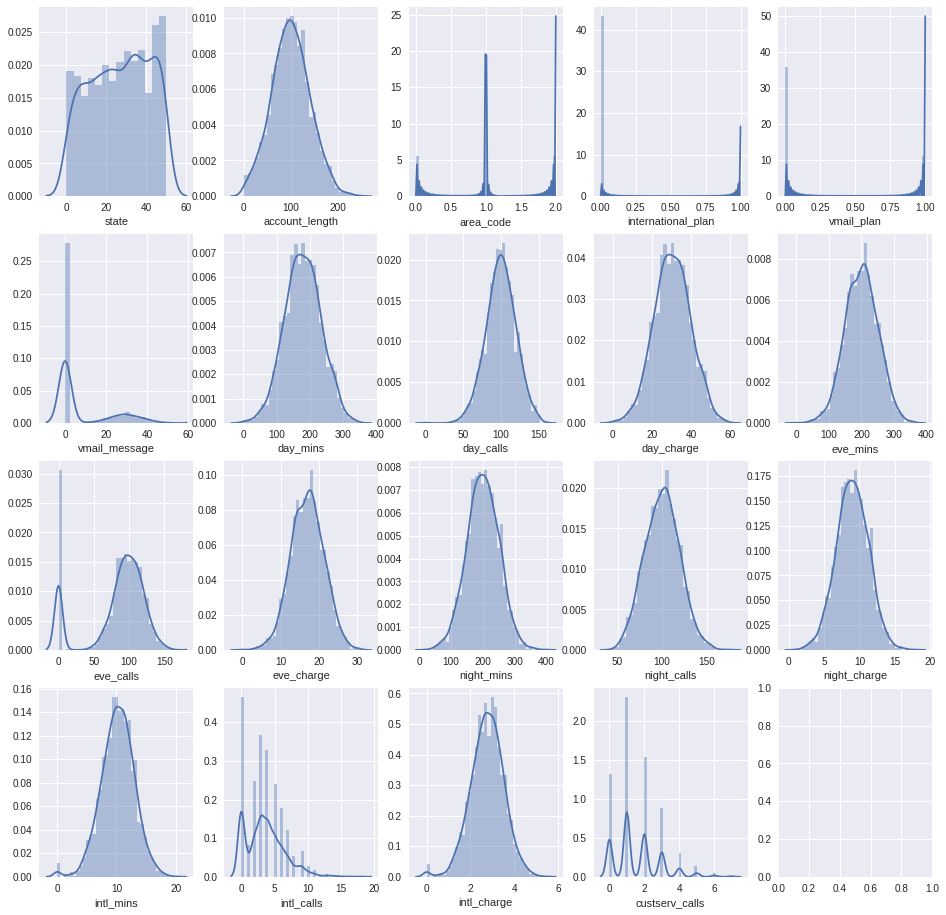

In [147]:
fig, axs = plt.subplots(4, 5, figsize=(16, 16))

for ix, col in enumerate(train_enc.columns):
    p0 = ix // 5
    p1 = ix % 5
    
    sns.distplot(train_enc[col], ax=axs[p0, p1])
    axs[p0, p1].set(xlabel=col)

Most of the continuous variables have bell shaped curves. There are only 3 area codes. The number of data entries per state seem to be relatively consistent across states.

### Relationships with Churn

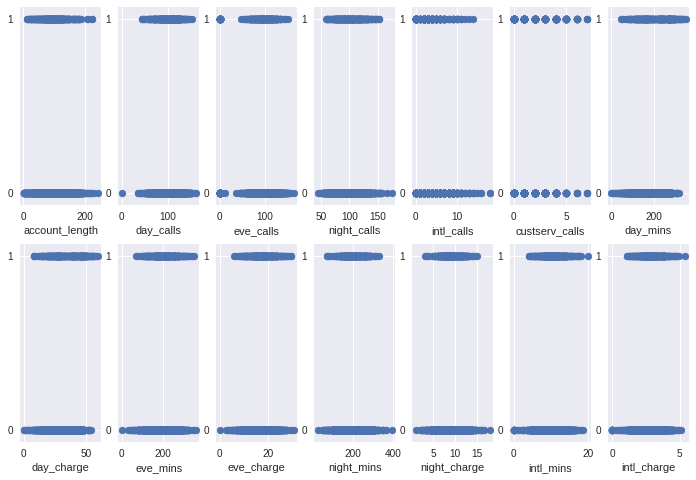

In [13]:
fig, axs = plt.subplots(2, 7, figsize=(12, 8))

for ix, feature in enumerate(integer_features+continuous_features):
    p0 = ix // 7
    p1 = ix % 7
    
    axs[p0, p1].scatter(train_enc[feature], churn)
    axs[p0, p1].set(xlabel=feature)

There are no features here that would allow churn to be separable by something like a logistic function. However, there are hints that those that churn do not tend to have low charges.

## Modeling

We've talked a lot about Logistic Regression so far, but there are a **lot** of classification models that you could use. In this section you will get a chance to do a little bit of research about 5 important classification algorithms. 

The purpose of this section is to give you a very very brief introduction to a few of the most popular supervised learning classification algorithms. It is **not** the purpose of this section/assignment that you understand all of the mathematical and programmatic inner-workings of these algorithms, but rather to give you a high level overview of their usage. Please defer your curiosity and perfectionism temporarily and focus on what you need to know in order to get an out-of-the box prediction from these classifiers using the sklearn library.

*   Support Vector Machine
*   Decision Tree Classifier
*   Random Forest Classifier
*   Naive Bayes Classifier
*   K-Nearest Neighbors Classifier


Once you have successfully fit each of these models to the test dataset and calculated their out-of-the-box ROC_AUC score, pick the top two highest performing classifiers and research their hyperparameters for future hyperparameter tuning.

List their hyperparameters here:

### Highest performing model's hyperparameters:

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

### Second highest performing model's hyperparameters:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


### Baseline Models

I will use two baselines. Both will be logistic regression models, one fit on all of the features, as well as the best performing univariate model.

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

from google.colab import files

In [0]:
def submit(X, Y, model, X_test, fit=True):
    if fit:
        model.fit(X, Y)
    yhat = model.predict(X_test)
    yhat = np.round(yhat)
    
    submit = submit_raw.copy()
    submit['churn'] = yhat
    submit.to_csv('submit.csv', index=False)
    
    files.download('submit.csv')

In [16]:
X = train_enc.as_matrix()
Y = churn.values.ravel()
X_test = test_enc.as_matrix()

model = LogisticRegression()
scores = cross_val_score(model, X, Y, cv=3, scoring='roc_auc')
print("Mean AUC Score - Logistic Regression: ", scores.mean())

submit(X, Y, model, X_test)
# score: 0.58445

Mean AUC Score - Logistic Regression:  0.8024585946771395


In [17]:
best_score = 0
best_feature = None
best_model = None
for feature in train_enc.columns:
    X = train_enc[[feature]].as_matrix()
    model = LogisticRegression()
    scores = cross_val_score(model, X, Y, cv=3, scoring='roc_auc')
    
    score = scores.mean()
    if score > best_score:
        best_score = score
        best_model = model
        best_feature = feature
        
print("Mean AUC Score - Logistic Regression: ", best_score)

submit(train_enc[[best_feature]].as_matrix(), Y, best_model, test_enc[[best_feature]].as_matrix())

# score: 0.50000

Mean AUC Score - Logistic Regression:  0.6428929428728093


### Out-of-the-box Models

I will try the models on 4 versions of the data, two without the `state` feature, and two that are scaled, and the appropriate combinations of these aspects.

In [0]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

In [0]:
X = train_enc.drop('state', axis=1).as_matrix()
X_state = train_enc.as_matrix()
X_scaled = train_enc_scaled.drop('state', axis=1).as_matrix()
X_scaled_state = train_enc_scaled.as_matrix()

X_test = test_enc.drop('state', axis=1).as_matrix()
X_test_state = test_enc.as_matrix()
X_test_scaled = test_enc_scaled.drop('state', axis=1).as_matrix()
X_test_scaled_state = test_enc_scaled.as_matrix()

In [20]:
X_variants = [X, X_state, X_scaled, X_scaled_state]
X_names = ['X without state', 'X with state', 'X scaled without state', 'X scaled with state']

for train_X, X_name in zip(X_variants, X_names):
    print('Data:', X_name)
    svc = SVC()
    svc_scores = cross_val_score(svc, train_X, Y, cv=3, scoring='roc_auc')
    print("Mean AUC Score - SVC: ", svc_scores.mean())

    decision_tree = DecisionTreeClassifier()
    decision_tree_scores = cross_val_score(decision_tree, train_X, Y, cv=3, scoring='roc_auc')
    print("Mean AUC Score - Decision Tree: ", decision_tree_scores.mean())

    random_forest = RandomForestClassifier()
    random_forest_scores = cross_val_score(random_forest, train_X, Y, cv=3, scoring='roc_auc')
    print("Mean AUC Score - Random Forest: ", random_forest_scores.mean())

    naive_bayes = GaussianNB()
    naive_bayes_scores = cross_val_score(naive_bayes, train_X, Y, cv=3, scoring='roc_auc')
    print("Mean AUC Score - Naive Bayes: ", naive_bayes_scores.mean())

    knn = KNeighborsClassifier()
    knn_scores = cross_val_score(knn, train_X, Y, cv=3, scoring='roc_auc')
    print("Mean AUC Score - KNN: ", knn_scores.mean())
    print('\n')

Data: X without state
Mean AUC Score - SVC:  0.5010121039943636
Mean AUC Score - Decision Tree:  0.8115716433066683
Mean AUC Score - Random Forest:  0.8764658863491356
Mean AUC Score - Naive Bayes:  0.8314302103719751
Mean AUC Score - KNN:  0.6510842368408891


Data: X with state
Mean AUC Score - SVC:  0.500552849461422
Mean AUC Score - Decision Tree:  0.8084486545991615
Mean AUC Score - Random Forest:  0.8643936205752466
Mean AUC Score - Naive Bayes:  0.830738426912451
Mean AUC Score - KNN:  0.6528291318692109


Data: X scaled without state
Mean AUC Score - SVC:  0.8876609277334541
Mean AUC Score - Decision Tree:  0.8102547443391904
Mean AUC Score - Random Forest:  0.8708383249467738
Mean AUC Score - Naive Bayes:  0.8314302103719751
Mean AUC Score - KNN:  0.805815117203673


Data: X scaled with state
Mean AUC Score - SVC:  0.8863699854616343
Mean AUC Score - Decision Tree:  0.813550400854176
Mean AUC Score - Random Forest:  0.88045449397363
Mean AUC Score - Naive Bayes:  0.83073842691

The best two out-of-the-box models are the SVC, training on the scaled data without `state`, and the random forest, on the unscaled data without `state`

## Evaluation

Start off by making a submission to the Kaggle leaderboard that is purely a column of all 1s or 0s as a baseline. There is a sampleSubmission.csv file that is already prepared in this format if you would like to use that.

Pick one of the better models from your out-of-the-box analysis and then use it to make predictions on the test dataset. Then take those predictions and make a new submission to the leaderboad. You are allowed 20 submissions to the leaderboard per day, so don't go submitting willy nilly.

Try and ensure that you have truly improved your classifier before making a new submission. Use the cross-validation techniques that we have been studying to evaluate your model on the training dataset before going to the trouble of making predictions on the test dataset and having to format a new submission.

In [0]:
submit(X_scaled, Y, svc, X_test_scaled)
# mean auc: 0.88766, test auc: 0.74158

submit(X, Y, random_forest, X_test)
# mean auc: 0.87647, test auc: 0.74581

## Repeat

The Machine Learning Framework is a cycle. Keep on looping through it and improving your classifier. Don't delete your previous work since we want to see how your thinking developed. Go back and try some hyperparameter tuning, format additional columns/features so that they are ready to be fed to the model. Keep on working down below, don't be afraid to add lots of code cells to your Colab.

## Stretch Goal:

Try and get the highest score that you possibly can. If you're not on the top of the leaderboard, then there must still be ways to improve your classifier that you haven't considered yet.

### Feature Selection
I will work with the random forest model to begin with. To find the best set of features, I will run backward feature elimination (beginning with all of the features, remove the feature that the model performs best without, until no more improvements can be made).

In [68]:
from sklearn.feature_selection import RFE
from sklearn.model_selection import StratifiedKFold

model = RandomForestClassifier()

rfe = RFE(estimator=model, step=1)
scores = cross_val_score(rfe, X, Y, cv=3, scoring='roc_auc')
print("Mean AUC Score - Random Forest: ", scores.mean())

Mean AUC Score - Random Forest:  0.8172285066932288


In [0]:
submit(X, Y, rfe, X_test) # score: 0.74586

There is less of a gap between the CV and the test AUC scores, indicating that less overfitting is taking place.

In [0]:
rfe.fit(X, Y)
X_sub = np.delete(X, np.arange(18)[~rfe.support_], axis=1)
X_test_sub = np.delete(X, np.arange(18)[~rfe.support_], axis=1)
X_scaled_sub = np.delete(X_scaled, np.arange(18)[~rfe.support_], axis=1)
X_test_scaled_sub = np.delete(X_test_scaled, np.arange(18)[~rfe.support_], axis=1)

In [161]:
(train_enc.columns[1:])[rfe.support_]

Index(['international_plan', 'day_mins', 'day_charge', 'eve_mins',
       'eve_charge', 'night_mins', 'night_charge', 'intl_charge',
       'custserv_calls'],
      dtype='object')

### Hyperparameter Tuning

I will try tuning the hyperparameters of the SVC and the Random Forest

In [111]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = range(1, 21)
max_features = range(1, X_sub.shape[1]//2)
min_samples_split = range(X_sub.shape[0]//20, X_sub.shape[0]//5, 20)
hyperparameters = dict(n_estimators=n_estimators, 
                       max_features=max_features, 
                       min_samples_split=min_samples_split)

model = RandomForestClassifier()
clf = RandomizedSearchCV(model, hyperparameters, n_iter=500, cv=3, scoring='roc_auc', random_state=41)

clf.fit(X_sub, Y)
print("Mean AUC Score - Random Forest: ", clf.best_score_)

Mean AUC Score - Random Forest:  0.8795256717377514


In [0]:
submit(X, Y, clf.best_estimator_, X_test) # score: 0.59496

### Ensembling
I will try combining the results of 2 or more classifiers.

In [127]:
from sklearn.ensemble import VotingClassifier

logistic = LogisticRegression()
svc = SVC(probability=True)
random_forest = RandomForestClassifier()
naive_bayes = GaussianNB()
knn = KNeighborsClassifier()

estimators = [('lr', logistic), ('svc', svc), ('rf', random_forest), 
              ('nb', naive_bayes), ('knn', knn)]

ens = VotingClassifier(estimators, voting='soft')
scores = cross_val_score(ens, X_scaled_sub, Y, cv=3, scoring='roc_auc')
print("Mean AUC Score - Random Forest: ", scores.mean())

Mean AUC Score - Random Forest:  0.8849171866023703


In [128]:
submit(X_scaled_sub, Y, ens, X_test_scaled_sub) # score: 0.73212

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### State Data
A lot of data might be thrown away since I am not considering the state. Since there are too many states to one hot encode, considering the amount of data, and they are not meaningfully ordered, I will try reporting state-based statistics instead.

In [0]:
def replace_category_with_churn_frequency(data, category, from_):
    by_category = from_.groupby(category)['churn'].mean()
    
    data[category] = from_[category].replace(dict(by_category))
    return data

In [207]:
train_enc = replace_category_with_churn_frequency(train_enc, 'state', train_raw)
display(train_enc.head())

test_enc = replace_category_with_churn_frequency(test_enc, 'state', test_raw)
train_enc_scaled = replace_category_with_churn_frequency(train_enc_scaled, 'state', train_raw)
test_enc_scaled = replace_category_with_churn_frequency(test_enc_scaled, 'state', test_raw)

,state,account_length,area_code,international_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,eve_mins,eve_calls,eve_charge,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,custserv_calls
0,0.170213,100,2,1,0,0,107.2,98,18.22,86.8,122,7.38,156.2,117,7.030000,9.7,4,2.62,1
1,0.170213,146,0,0,1,23,149.6,96,25.43,239.8,124,20.38,293.5,135,13.210000,7.4,4,2.00,2
2,0.055556,84,1,0,0,0,159.0,80,27.03,167.9,128,14.27,167.6,101,7.540000,12.3,5,3.32,1
3,0.111111,43,0,0,0,0,135.8,125,23.09,163.2,88,13.87,229.8,106,10.340000,12.6,0,3.40,0
4,0.222222,101,1,0,0,0,193.7,108,32.93,186.6,0,15.86,223.0,100,10.034979,11.6,8,3.13,0


In [209]:
X = train_enc.as_matrix()
X_test = test_enc.as_matrix()

X_scaled = train_enc_scaled.as_matrix()
X_test_scaled = test_enc_scaled.as_matrix()

svc = SVC()
scores = cross_val_score(svc, X_scaled, Y, cv=3, scoring='roc_auc')
print("Mean AUC Score - SVC: ", scores.mean())

rf = RandomForestClassifier()
scores = cross_val_score(rf, X, Y, cv=3, scoring='roc_auc')
print("Mean AUC Score - Random Forest: ", scores.mean())

Mean AUC Score - SVC:  0.8884270721721793
Mean AUC Score - Random Forest:  0.87346441743229


In [0]:
submit(X, Y, rf, X_test) # score: 0.76059

#### Feature Selection

In [220]:
model = RandomForestClassifier()

rfe = RFE(estimator=model, step=1)
scores = cross_val_score(rfe, X, Y, cv=3, scoring='roc_auc')
print("Mean AUC Score - Random Forest: ", scores.mean())

Mean AUC Score - Random Forest:  0.8279636636421359


In [0]:
submit(X, Y, rfe, X_test) # score: 0.78284

#### More Estimators

In [221]:
model = RandomForestClassifier(n_estimators=50)

rfe = RFE(estimator=model, step=1)
scores = cross_val_score(rfe, X, Y, cv=3, scoring='roc_auc')
print("Mean AUC Score - Random Forest: ", scores.mean())

Mean AUC Score - Random Forest:  0.8602463684093742


In [0]:
submit(X, Y, rfe, X_test) # score: 0.72558

#### Gradient Boosting

In [226]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier()
scores = cross_val_score(model, X, Y, cv=3, scoring='roc_auc')
print("Mean AUC Score - Gradient Boosting: ", scores.mean())

Mean AUC Score - Gradient Boosting:  0.9031022767116715


In [0]:
submit(X, Y, model, X_test) # score: 0.82922

In [241]:
model = GradientBoostingClassifier()

rfe = RFE(estimator=model, step=1)
scores = cross_val_score(rfe, X, Y, cv=3, scoring='roc_auc')
print("Mean AUC Score - Gradient Boosting: ", scores.mean())

Mean AUC Score - Gradient Boosting:  0.8554410132963648


In [0]:
submit(X, Y, rfe, X_test) # score: 0.73649